# Machine Learning for Composer Classification Using Musical Scores

## Introduction

The art of music, with its unique styles and compositions, presents an intriguing challenge: the identification of composers. This machine learning project aims to address this complex task, a notable obstacle for novice musicians or listeners. Using the deep learning frames, the project's methodology initiates with the importing of essential libraries and the `Composer` dataset, containing both MIDI files and sheet music. The core process encompasses data pre-processing, transforming musical scores into deep learning-compatible formats, and feature extraction to discern notes, chords, and tempo. Utilizing LSTM and CNN architectures, a tailored model is constructed, trained, and optimized to classify musical scores by composers. Its performance is evaluated and visualized, demonstrating the successful application of deep learning in enhancing our understanding of musical compositions.

# Data Loading

### Dataset Summary

The `Composer` dataset is provided in the assignement and comprised of 439 MIDI files for music composition style classification across 9 composers: Bach, Bartok, Byrd, Chopin, Handel, Hummel, Mendelssohn, Mozart and Schumann.

The data is split into train, validation and test sets as follows:
- Training set: 349 MIDI files
- Validation set: 32 MIDI files
- Test set: 58 MIDI files

The files are organized into folders per composer, with subfolders for each split into train, dev and test folders each containing 1 subfolder per composer with varying number of MIDI files

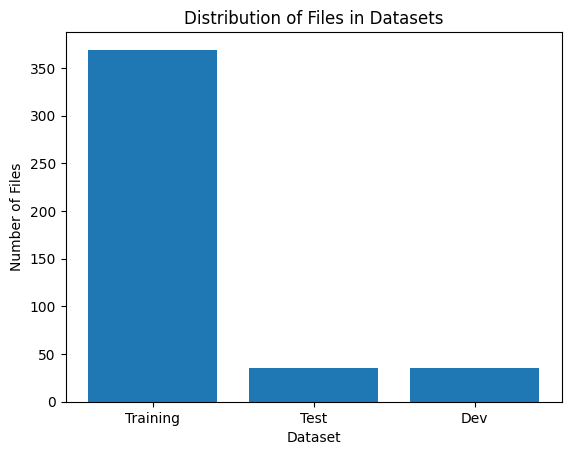

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt


def count_files_in_folder(folder_path):
    return sum([len(files) for _, _, files in os.walk(folder_path)])

def visualize_distribution(data, labels, title):
    plt.bar(labels, data)
    plt.xlabel('Dataset')
    plt.ylabel('Number of Files')
    plt.title(title)
    plt.show()

train_folder = 'NN_midi_files_extended/train'
test_folder = 'NN_midi_files_extended/test'
dev_folder = 'NN_midi_files_extended/dev'

train_count = count_files_in_folder(train_folder)
test_count = count_files_in_folder(test_folder)
dev_count = count_files_in_folder(dev_folder)

data = [train_count, test_count, dev_count]
labels = ['Training', 'Test', 'Dev']
title = 'Distribution of Files in Datasets'

visualize_distribution(data, labels, title)

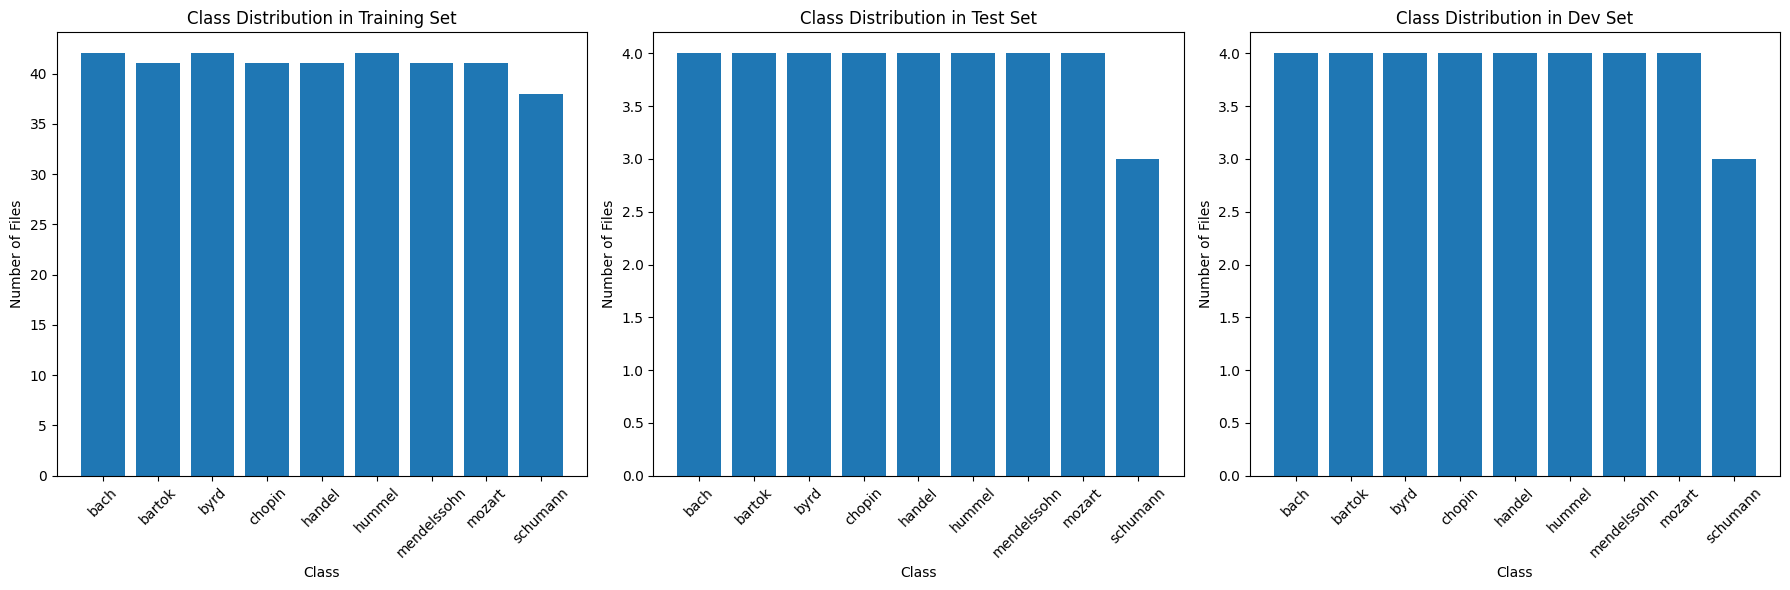

In [2]:
def count_files_in_folder(folder_path):
    return sum([len(files) for _, _, files in os.walk(folder_path)])

def visualize_class_distribution(ax, dataset_path, class_labels, title):
    class_counts = {label: count_files_in_folder(os.path.join(dataset_path, label)) for label in class_labels}
    class_df = pd.DataFrame(class_counts.items(), columns=['Class', 'Count'])
    
    ax.bar(class_df['Class'], class_df['Count'])
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Files')
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=45)

# Define class labels and dataset folders
class_labels = ['bach', 'bartok', 'byrd', 'chopin', 'handel', 'hummel', 'mendelssohn', 'mozart', 'schumann']
train_folder = 'NN_midi_files_extended/train'
test_folder = 'NN_midi_files_extended/test'
dev_folder = 'NN_midi_files_extended/dev'

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot class distributions in each dataset
visualize_class_distribution(axes[0], train_folder, class_labels, 'Class Distribution in Training Set')
visualize_class_distribution(axes[1], test_folder, class_labels, 'Class Distribution in Test Set')
visualize_class_distribution(axes[2], dev_folder, class_labels, 'Class Distribution in Dev Set')

# Adjust layout
plt.tight_layout()
plt.show()


## Data Pre-processing

The preprocessing phase was instrumental in preparing data from MIDI files to feed into our CNN model designed for multi-class classification. Recognizing the need for one or more channels of a 2D array, we strategically explored the conversion of musical information into compatible formats. By focusing on piano roll, beats, and down-beats, we were able to analyze and transform this information into structured data. This approach enabled the neural network to access and learn from the essential characteristics that define different musical compositions, enhancing the accuracy of our classification efforts

In [3]:
import pretty_midi as pm
import torchaudio
import torch
import os
import numpy as np
import pandas as pd
import pygame  
import warnings 
from multiprocessing import Pool
import pretty_midi as pm
import os
import matplotlib.pyplot as plt
from collections import defaultdict

pygame 2.5.0 (SDL 2.28.0, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


#### Data exploration

# A Note About MIDI File and the PrettyMidi Library

### MIDI Files:

MIDI (Musical Instrument Digital Interface) files are a standard protocol that encapsulates various attributes of music such as notes, timing, velocity, and more. Unlike conventional audio files, MIDI files store a series of messages and control instructions, allowing instruments, synthesizers, and computer programs to interpret and perform the music.

In [4]:
#Exploring one MidiFile
data_path = '/home/jupyter/msaai/NeuralNetworks/Module7/final-project/NN_midi_files_extended/train/bach/bach346.mid'
midi_stream = pm.PrettyMIDI(data_path)

### PrettyMidi Library:
PrettyMidi is a versatile Python library crafted for managing MIDI files and their intricate structure. It facilitates tasks like music analysis, synthesis, and more by offering a host of methods, including:

**Accessing Instruments:** By using `pretty_midi.instruments`, you can obtain a list of all instruments in the file. This encompasses detailed information about notes (including pitch and start/end times), pitch bends, velocity, and control changes, allowing for granular analysis and manipulation.

**Extracting Piano Roll:** The `get_piano_roll` method is instrumental in acquiring a piano roll representation, illustrating the pitches and their corresponding timings.

**Chromagram Extraction:** With `pretty_midi.get_chroma`, you can extract a chromagram, summary of the the energy distribution of pitches across the 12 pitch classes. This can be used to analyze harmonies and chords in the music.

In [5]:
# Extract notes pitch, velocity start and end times
notes = midi_stream.instruments[0].notes
note_data = [[n.pitch, n.velocity, n.start, n.end] for n in notes]


# Extract notes pitch vs time
piano_roll = midi_stream.get_piano_roll(fs=100)


# Extract Energy distribution across 12 pitch classes
chromagram = midi_stream.get_chroma(fs=100)

### Visualizing the features

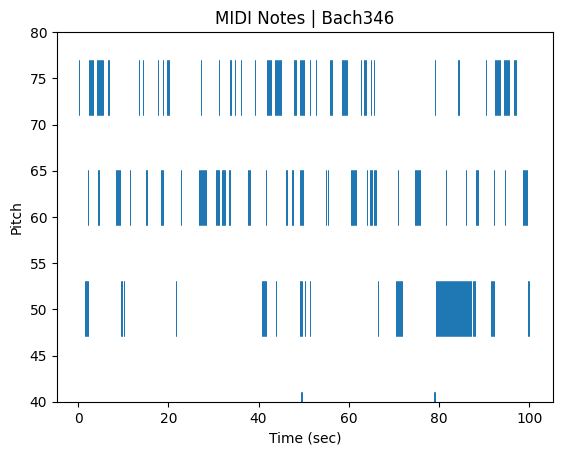

In [6]:
note_data = [[n.start, n.end, n.pitch, n.velocity] for n in notes]
start_times, end_times, pitches, velocities = zip(*note_data) 


# Plot 
fig, ax = plt.subplots()

for start, end, pitch, velocity in note_data:
  ax.hlines(pitch, start, end, linewidth=40*velocity/127)

ax.set_ylim([40, 80]) # MIDI note range
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Pitch')
ax.set_title('MIDI Notes | Bach346')

plt.show()

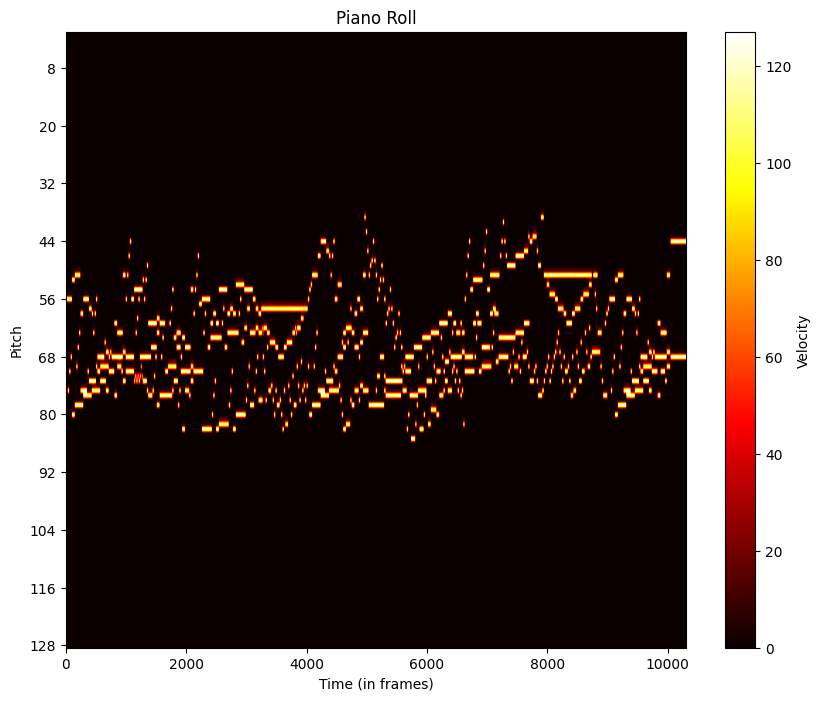

In [7]:
# Plot the piano roll

plt.figure(figsize=(10, 8))
plt.imshow(np.flip(piano_roll, 0), aspect='auto', origin='lower', cmap='hot')
plt.title('Piano Roll')
plt.ylabel('Pitch')
plt.xlabel('Time (in frames)')
plt.colorbar(label='Velocity')
plt.yticks(range(0, piano_roll.shape[0], 12), range(piano_roll.shape[0], 0, -12))
plt.show()


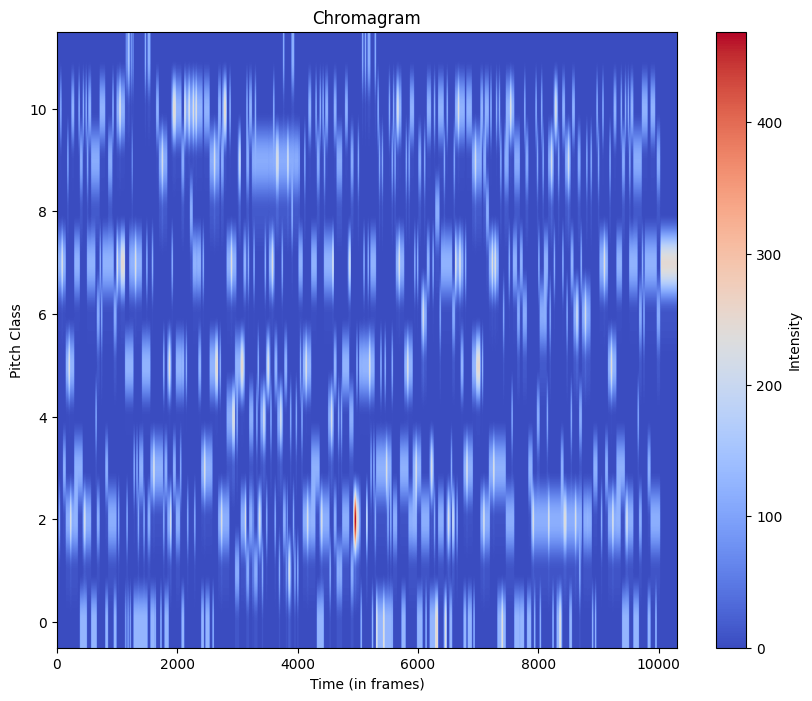

12


In [ ]:
# Plot the chromagram
plt.figure(figsize=(10, 8))
plt.imshow(chromagram, aspect='auto', origin='lower', cmap='coolwarm')
plt.title('Chromagram')
plt.ylabel('Pitch Class')
plt.xlabel('Time (in frames)')
plt.colorbar(label='Intensity')
plt.show()
print(len(chromagram))

### Get the shortest midi length in the dataset that will set the max length of the dataset, this will avoid padding in the future

In [ ]:
max_length = 128

# Feature selection

## Final set of features

Ater careful consideration and analysis of the MIDI files, the final set of features selected for our multi-class classification model were 'note_data' and 'chromagram'. The 'note_data' feature, which includes pitch, velocity, start and end times of notes, provides detailed information about each note in the music piece. This allows for a granular analysis of the music composition. On the other hand, 'chromagram' provides a summary of the energy distribution across 12 pitch classes, which can be used to analyze harmonies and chords in the music. It's important to note that there is an overlap of information between 'note_data' and 'piano_roll', as both provide information about pitches and their timings. These features were chosen as they encapsulate essential characteristics that define different musical compositions, thereby enhancing the accuracy of our classification efforts

### A note about Mel Spectrograms

Mel-spectrograms have often outperformed other features like MFCCs and chromagrams in audio classification tasks with deep learning, with CNN models achieving 90% accuracy using mel-spectrograms (Uchal & Zhou, 2019). Despite their effectiveness, we opted not to use Mel-spectrograms in our analysis, as conversion from MIDI to Wave or capturing this data would have entailed a high compute-intensive process with other libraries (Uchal & Zhou, 2019).

Reference:
Uchal, J., & Zhou, H. (2019). CLASSIFICATION USING DEEP NEURAL NETWORK. Retrieved from https://api.semanticscholar.org/CorpusID:202744438

### Load data note_data 

The function `extract_note_data` extracts note data from a MIDI file, including pitch, velocity, start and end times. It pads or truncates the data to a specified length.

In [ ]:
import pretty_midi as pm
from collections import defaultdict
import pandas as pd

def extract_note_data(midi_file, max_length):  
  # Load MIDI file
  print(f"Extracting Note Data from Midi ...... {midi_file}")
  try:
    midi_data = pm.PrettyMIDI(midi_file)
  except IOError as e:
    print(f"Error loading midi file: {e}")
    return None
  
  note_data = []
  
  # Iterate over the first 12 instruments
  for instrument in midi_data.instruments[:12]:
    # Get notes and sort them by start time
    notes = instrument.notes
    notes.sort(key=lambda n: n.start)

    for i, note in enumerate(notes):
      # Check for overlap add note data
      note_data.append([
        note.pitch,
        note.velocity,  
        note.start,
        note.end 
      ])
      
      if len(note_data) >= max_length:
        break

    # Break outer loop if max_length is reached
    if len(note_data) >= max_length:
      break

  # Pad each note data to length of 12
  for i in range(len(note_data)):
    while len(note_data[i]) < 12:
      note_data[i].append(0)

  # Pad if needed
  while len(note_data) < max_length: 
    note_data.append([0]*12)

  return note_data
  
note_data = extract_note_data(data_path, max_length)
note_data_df = pd.DataFrame(note_data)
note_data_df.info()

Extracting Note Data from Midi ...... /home/jupyter/msaai/NeuralNetworks/Module7/final-project/NN_midi_files_extended/train/bach/bach346.mid
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       128 non-null    int64  
 1   1       128 non-null    int64  
 2   2       128 non-null    float64
 3   3       128 non-null    float64
 4   4       128 non-null    int64  
 5   5       128 non-null    int64  
 6   6       128 non-null    int64  
 7   7       128 non-null    int64  
 8   8       128 non-null    int64  
 9   9       128 non-null    int64  
 10  10      128 non-null    int64  
 11  11      128 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 12.1 KB


In [ ]:
import pretty_midi
import numpy as np

def extract_chroma_data(midi_file, output_size):

  # Get raw chroma  
  print(f"Extracting Chroma from Midi ...... {midi_file}")
  midi_data = pretty_midi.PrettyMIDI(midi_file)
  chroma_raw = midi_data.get_chroma(fs=100)

  # Interpolate each column  
  chroma = np.zeros((output_size, 12))
  for i in range(12):
    col = chroma_raw[:,i]
    time_scaled = np.linspace(0, len(col), num=output_size)
    chroma[:,i] = np.interp(time_scaled, np.arange(len(col)), col)
  return chroma

note_chroma = extract_chroma_data(data_path,max_length)
note_chroma_df = pd.DataFrame(note_chroma)
note_chroma_df.info()

Extracting Chroma from Midi ...... /home/jupyter/msaai/NeuralNetworks/Module7/final-project/NN_midi_files_extended/train/bach/bach346.mid
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       128 non-null    float64
 1   1       128 non-null    float64
 2   2       128 non-null    float64
 3   3       128 non-null    float64
 4   4       128 non-null    float64
 5   5       128 non-null    float64
 6   6       128 non-null    float64
 7   7       128 non-null    float64
 8   8       128 non-null    float64
 9   9       128 non-null    float64
 10  10      128 non-null    float64
 11  11      128 non-null    float64
dtypes: float64(12)
memory usage: 12.1 KB


In [12]:
import os
import pandas as pd
from collections import defaultdict
import pretty_midi as pm
import numpy as np

def process_midi_files(midi_folder):

  composers = {'bach': 0, 'bartok': 1, 'byrd': 2, 'chopin': 3, 
               'handel': 4, 'hummel': 5, 'mendelssohn': 6, 
               'mozart': 7, 'schumann': 8}
               
  sets = ['train', 'dev', 'test']
  
  max_length = 128
  
  X_train, X_dev, X_test = [], [], []
  Y_train, Y_dev, Y_test = [], [], []
  sum = 0
  for set in sets:
    set_path = os.path.join(midi_folder, set)
    
    y = []
    for composer in composers:
      composer_path = os.path.join(set_path, composer)  
      for midi_file in os.listdir(composer_path):
        midi_path = os.path.join(composer_path, midi_file)
      
        # Extract features
        note_data = extract_note_data(midi_path, max_length)
        chroma = extract_chroma_data(midi_path, max_length)
        sum += 1
        print(sum," / 439")
      
        # Append to X
        if set == 'train':
          X_train.append(np.concatenate([note_data, chroma], axis=1)) 
        elif set == 'dev':
          X_dev.append(np.concatenate([note_data, chroma], axis=1))
        else:
          X_test.append(np.concatenate([note_data, chroma], axis=1))
      
        # Append to Y  
        y.append(composers[composer])
        
    # Create dataframe        
    if set == 'train':
      Y_train.extend(y)
    elif set == 'dev':
      Y_dev.extend(y) 
    else:
      Y_test.extend(y)
      
  return X_train, X_dev, X_test, Y_train, Y_dev, Y_test

X_train, X_dev, X_test, Y_train, Y_dev, Y_test = process_midi_files('NN_midi_files_extended/')

Extracting Note Data from Midi ...... NN_midi_files_extended/train/bach/bach345.mid
Extracting Chroma from Midi ...... NN_midi_files_extended/train/bach/bach345.mid
1  / 439
Extracting Note Data from Midi ...... NN_midi_files_extended/train/bach/bach369.mid
Extracting Chroma from Midi ...... NN_midi_files_extended/train/bach/bach369.mid
2  / 439
Extracting Note Data from Midi ...... NN_midi_files_extended/train/bach/bach346.mid
Extracting Chroma from Midi ...... NN_midi_files_extended/train/bach/bach346.mid
3  / 439
Extracting Note Data from Midi ...... NN_midi_files_extended/train/bach/bach386.mid
Extracting Chroma from Midi ...... NN_midi_files_extended/train/bach/bach386.mid
4  / 439
Extracting Note Data from Midi ...... NN_midi_files_extended/train/bach/bach363.mid
Extracting Chroma from Midi ...... NN_midi_files_extended/train/bach/bach363.mid
5  / 439
Extracting Note Data from Midi ...... NN_midi_files_extended/train/bach/bach373.mid
Extracting Chroma from Midi ...... NN_midi_fil

/opt/conda/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Extracting Chroma from Midi ...... NN_midi_files_extended/train/chopin/chopin052.mid
130  / 439
Extracting Note Data from Midi ...... NN_midi_files_extended/train/chopin/chopin076.mid
Extracting Chroma from Midi ...... NN_midi_files_extended/train/chopin/chopin076.mid
131  / 439
Extracting Note Data from Midi ...... NN_midi_files_extended/train/chopin/chopin079.mid
Extracting Chroma from Midi ...... NN_midi_files_extended/train/chopin/chopin079.mid
132  / 439
Extracting Note Data from Midi ...... NN_midi_files_extended/train/chopin/chopin096.mid
Extracting Chroma from Midi ...... NN_midi_files_extended/train/chopin/chopin096.mid
133  / 439
Extracting Note Data from Midi ...... NN_midi_files_extended/train/chopin/chopin082.mid
Extracting Chroma from Midi ...... NN_midi_files_extended/train/chopin/chopin082.mid
134  / 439
Extracting Note Data from Midi ...... NN_midi_files_extended/train/chopin/chopin089.mid
Extracting Chroma from Midi ...... NN_midi_files_extended/train/chopin/chopin089

## Model Building

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MidiClassifier(nn.Module):
    def __init__(self):
        super(MidiClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, (3, 3), padding=1)
        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(6144, 512)
        self.fc2 = nn.Linear(512, 9)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


# create a complete CNN
model = MidiClassifier()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MidiClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6144, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=9, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

### Model Architecture
 
- The first convolutional layer takes in a 1-channel image (the MIDI file) and outputs 16 feature maps. The second convolutional layer takes these 16 feature maps and outputs 32 feature maps. Both convolutional layers use a 3x3 kernel and have padding of 1 to maintain the spatial dimensions of the input.
- The max pooling layer is used to reduce the spatial size of the output volume, which decreases the amount of parameters and computation in the network. This helps to control overfitting.
- The fully connected layers are standard neural network layers where every input is connected to every output. The first fully connected layer has 512 outputs, and the second fully connected layer has 9 outputs, corresponding to the 9 classes we are trying to predict.
- The dropout layer randomly sets a fraction (in this case, 10%) of input units to 0 at each update during training time, which helps prevent overfitting.

# Training and Validation

### Convert DataFrames to Tensors

In [14]:
X_train = torch.from_numpy(np.array(X_train)).float()
X_test = torch.from_numpy(np.array(X_test)).float() 
X_dev = torch.from_numpy(np.array(X_dev)).float() 

Y_train = torch.from_numpy(np.array(Y_train)).long()
Y_test = torch.from_numpy(np.array(Y_test)).long()
Y_dev = torch.from_numpy(np.array(Y_dev)).long()

### Train and Validate

In [22]:
import torch
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Define the training function
def train_model(model, criterion, optimizer, dataloader):
    model.train()  # Set model to training mode
    running_loss = 0.0  # Keep track of running loss
    
    try:
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move tensors to device
            #print("Train: Loop: X_batch.size()",X_batch.size(),"y_batch.size()", y_batch.size())
            # Forward pass
            y_pred = model(X_batch)
            
            # Compute loss
            loss = criterion(y_pred, y_batch)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * X_batch.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        return epoch_loss
    
    except Exception as e:
        print(f'Error occurred during training: {e}')

# Define the validation function
def validate_model(model, criterion, dataloader):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    
    try:
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move tensors to device
            #print("Validate: loop: X_batch.size()",X_batch.size(),"y_batch.size()", y_batch.size())
            
            # Forward pass
            y_pred = model(X_batch)
            
            # Compute loss
            loss = criterion(y_pred, y_batch)
            
            running_loss += loss.item() * X_batch.size(0)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        return epoch_loss
    
    except Exception as e:
        print(f'Error occurred during validation: {e}')

# Define the testing function
def test_model(model, dataloader):
    model.eval() 
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move tensors to device
            
            y_pred = model(X_batch)
            _, predicted = torch.max(y_pred.data, 1)
            
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            
        acc = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro',zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro',zero_division=0)
        
        return acc, precision, recall

In [26]:
#Define dataset objects

X_train = X_train.view(-1, 1, 128, 24)
X_test = X_test.view(-1, 1, 128, 24)
X_dev = X_dev.view(-1, 1, 128, 24)


print("X_train",X_train.shape)
print("Y_train",Y_train.shape)
print("Y_classes",Y_train.unique())
print("\n")

print("X_test",X_test.shape)
print("Y_test",Y_test.shape)
print("Y_test",Y_test.unique())
print("\n")

print("X_dev",X_dev.shape)
print("Y_dev",Y_dev.shape)
print("Y_dev",Y_dev.unique())

train_data = torch.utils.data.TensorDataset(X_train, Y_train)
test_data = torch.utils.data.TensorDataset(X_test, Y_test)
val_data = torch.utils.data.TensorDataset(X_dev, Y_dev)

X_train torch.Size([369, 1, 128, 24])
Y_train torch.Size([369])
Y_classes tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])


X_test torch.Size([35, 1, 128, 24])
Y_test torch.Size([35])
Y_test tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])


X_dev torch.Size([35, 1, 128, 24])
Y_dev torch.Size([35])
Y_dev tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])


## Model Optimization

In [46]:
learning_rate = 0.001
num_epochs=60
best_acc = 0.0  # Keep track of best accuracy
train_losses = []  # Keep track of training losses for plotting
val_losses = []  # Keep track of validation losses for plotting
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=False)

# Define CNN model, optimizer, loss criterion
# Check if GPU is available and if not, use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MidiClassifier().to(device) 
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

# Train the model and validate after each epoch
for epoch in range(num_epochs):
    train_loss = train_model(model, criterion, optimizer, train_loader)
    val_loss = validate_model(model, criterion, val_loader) 
    
    # Store the losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Print every nth epoch
    if (epoch+1) % 2 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Test the model after training
acc, precision, recall = test_model(model, test_loader)

print(f'Test Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

Epoch 2/60, Train Loss: 2.6121, Val Loss: 3.1723
Epoch 4/60, Train Loss: 1.9165, Val Loss: 2.2850
Epoch 6/60, Train Loss: 1.6917, Val Loss: 2.0722
Epoch 8/60, Train Loss: 1.4622, Val Loss: 2.0531
Epoch 10/60, Train Loss: 1.3619, Val Loss: 1.7409
Epoch 12/60, Train Loss: 1.2891, Val Loss: 1.8225
Epoch 14/60, Train Loss: 1.1951, Val Loss: 1.7529
Epoch 16/60, Train Loss: 1.1441, Val Loss: 1.8644
Epoch 18/60, Train Loss: 1.1074, Val Loss: 1.8223
Epoch 20/60, Train Loss: 1.0806, Val Loss: 1.8013
Epoch 22/60, Train Loss: 1.0973, Val Loss: 1.7901
Epoch 24/60, Train Loss: 1.0045, Val Loss: 1.7567
Epoch 26/60, Train Loss: 0.9797, Val Loss: 1.7245
Epoch 28/60, Train Loss: 0.9373, Val Loss: 1.7858
Epoch 30/60, Train Loss: 0.9411, Val Loss: 1.7493
Epoch 32/60, Train Loss: 0.9196, Val Loss: 1.7839
Epoch 34/60, Train Loss: 0.8881, Val Loss: 1.7471
Epoch 36/60, Train Loss: 0.8948, Val Loss: 1.7949
Epoch 38/60, Train Loss: 0.8773, Val Loss: 1.7798
Epoch 40/60, Train Loss: 0.8111, Val Loss: 1.7556
Epoc

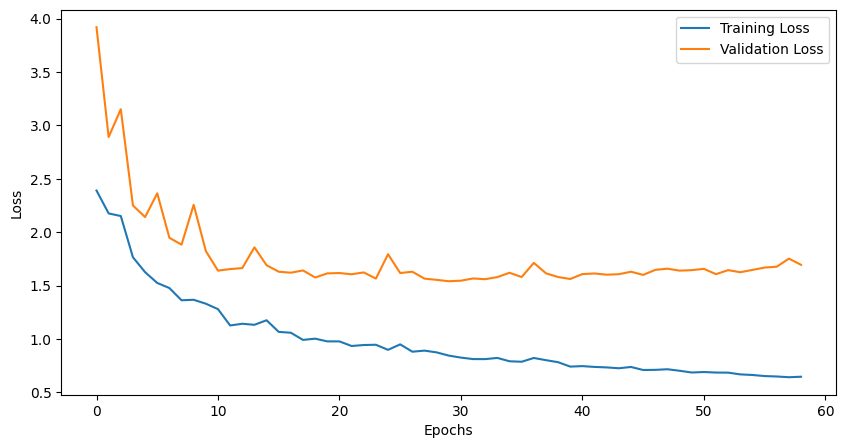

In [39]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses[1:], label='Training Loss')
plt.plot(val_losses[1:], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Over the course of 25 epochs, the model's training loss consistently decreased from 5.0811 to 0.8622, demonstrating the ability to learn from the training data. Concurrently, the validation loss initially saw a significant reduction but then showed fluctuations, reaching a low of 1.6329 and ending at 1.7081. The test accuracy, precision, and recall further quantify the model's performance, with an accuracy of 60%. S

### Divergence Between Training and Validation Loss

The divergence between training and validation loss suggests a disparity between the model's performance on the training data and unseen data. While the training loss steadily decreases, the validation loss doesn't show the same consistent behavior, and even slightly increases in later epochs. This divergence might indicate overfitting, where the model is becoming too specialized in handling the training data and loses its generalizing ability on new, unseen data.

# Conclusion


Strategies for Improvement
Although the model The outlined strategies for improving model performance can be mapped to the observed performance trends:

Larger Dataset: By increasing the size of the dataset, the model may gain more robust insights, potentially reducing the divergence between training and validation loss.
Better Data Representation: Enhancing the representation may lead to more meaningful learning, aiding the generalization of the model.
More Compute for Hyperparameter Search: An optimal set of hyperparameters might achieve a more consistent reduction in validation loss, aligning it more closely with the training loss.
Incorporate Additional Features: Including more features could provide the model with a richer understanding of the underlying patterns, improving validation performance.
Use OneHot Encoding for MIDI Channels: Preserving channel information may lead to more nuanced learning and reduce divergence between training and validation.
Apply Regularization Techniques: Regularization can minimize overfitting, thereby aligning training and validation loss more closely.
In summary, the divergence between training and validation loss in the given effort highlights potential overfitting and underscores the need for strategies to enhance generalization. Incorporating the proposed improvements may lead to a more harmonized learning process, increasing the model's effectiveness in handling unseen data, which is essential for a robust multi-class classification solution.